# ECS7020P_miniproject_advance

# 1 Author

**Student Name**: Yiu Hang Cheung  
**Student ID**:  220777713

# 2 Problem formulation

In the basic part, a machine learning pipeline is built to predict if an audio segment is recorded indoor or outdoor, which is a binary classification problem.

In this advanced component, a multiclass classification problem is investigated. 

The objective is to use a subset of the MLEnd London Sounds dataset, which only consists of one area, to build a machine learning pipeline that takes an audio segment as an input to predict the recording spot of the area. 

Regarding the dataset, the distribution in area is unbalanced. Almost 1/3 of the recordings are taken in the campus and another 1/3 from the westend area. The campus is chosen because it has the most samples for training.

# 3 Machine Learning pipeline

Similar to the basic part, the inputs are the raw audio files. 

They are passed into the machine learning pipeline which includes the feature extraction, data standardisation and the model.

For the feature extraction part, each raw audio file is loaded and transformed into 2 audio time series: 1 for the first 3 seconds, 1 for the following 3 seconds.

The first 3 seconds of the audio segment contains the voice of the participant and the following 3 seconds contains only the background sound.

Then the Mel-frequency cepstral coefficients (MFCC), root mean square (RMS) value, zero-crossing rate and the spectral flatness are computed. They are the attributes to be passed into the model for training.

Before training the model, the attributes are normalised.

The model is then trained and final output is an array of predicted probabilities of each label (recording spot). The one with the highest probability is the predicted label, which is converted into 0 to 5:

**0: 'canal', 1: 'curve', 2: 'ground', 3: 'library', 4: 'reception', 5: 'square'**

# 4 Transformation stage

**The transformation stage is almost the same as in the basic component except 40 Mel-frequency cepstral coefficients (MFCC) are extracted in this advance component. The details are recapped as follows.**

The transformation stage includes feature extraction and standardisation.

The raw audio files and their corresponding labels are the inputs.

The feature extraction part is carried out by the getXy function, which uses several feature extraction functions from the librosa library.

Step 1: load each audio segment to get 2 scaled audio time series: 1 for the first 3 seconds, 1 for the following 3 seconds.

Step 2: pass the 2 audio time series to extract the following features:

 - 40 Mel-frequency cepstral coefficients (MFCC) in which each MFCC captures certain details of the spectral envelope of the audio signal; 
    
 - root mean square (RMS) value which measures the average loudness;
 
 - zero-crossing rate which is an indicator to measure the fluctation of the audio wave; and
    
 - spectral flatness which quantify how much noise-like a sound is.
    
All the above feature extraction functions will return the values of each frame so the mean is computed over the number of frames of each audio time series.

As a result, 86 attributes are obtained for each audio segment (40+3)x2 and the getXy function returns an array of attributes X and an array of the corresponding labels y.

Step 3: standardise the attributes (z=x−μ/σ) so they are ready to be passed into the model. This is done after the getXy function, right before passing them into the model.

# 5 Modelling

Predicting the recording spot is a more complicated task and requires more features than in the basic component.<br>
Therefore, neural network is chosen to solve this problem.

A major advantage of neural network is that it offers high flexibility to suit problems of different complexity by adjusting the number of layers and the number of perceptrons per layer.

More concepts can be introduced per layer by adding more perceptrons to a layer and the complexity of the concepts can be increased by adding more layers.

A neural network architecture is built with following layers:

The model consists of an input layer which takes the 86 attributes.

Following that are 2 dense layers with each layer having 128 perceptrons and are activated by rectified linear unit (ReLU).

The final layer is an output layer activated by softmax function, which returns the probabilities of each label.

To prevent over fitting, dropout layers are added between layers meaning that part of the perceptrons are inactivated during training.

# 6 Methodology

All samples which belong to the campus are split into a training set, which contains 70% of the samples, and a validation set, which contains the remaining 30% of the samples.

The model is trained with the features extracted. The number of epochs is set to 100 and the batch size is 32, meaning that the model is trained with 32 training samples in one iteration and this process is repeated 100 times.

4 parameters are monitored during the training process. They are the training accuracy, training loss, validation accuracy and validation loss.

Early stopping is used when the validation loss does not drop further for 10 iterations, which is another measure to avoid overfitting.

The performance is basically assessed by the training and validation accuracies.

Moreover, a confusion matrix is generated to visualise the predicted labels and calculate the precision, sensitivity and F1-score of predicting each spot.

# 7 Dataset

In [1]:
import pandas as pd

MLENDLS_df = pd.read_csv('MLEndLS.csv').set_index('file_id')

In [2]:
MLENDLS_df.groupby('area')['spot'].value_counts()

area        spot      
Euston      gardens        41
            library        41
            upper          41
            forecourt      40
            ritblat        36
            piazza         35
british     greatcourt     84
            room12         83
            forecourt      82
            square         77
            street         77
            room13          1
campus      square        142
            ground        139
            canal         137
            curve         136
            reception     136
            library       133
kensington  albert         26
            hintze         26
            dinosaur       25
            marine         24
            pond           22
            cromwell       21
southbank   waterloo       41
            bridge         40
            skate          40
            food           39
            book           36
            royal          33
westend     piazza        116
            charing       113
            marke

In [3]:
MLENDLS_df = MLENDLS_df.drop(index = ['0762.wav'], axis = 0)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, re, pickle, glob
import urllib.request
import IPython.display as ipd
from tqdm import tqdm
import librosa

In [5]:
dataset_path = './dataset/*.wav'
files = glob.glob(dataset_path)

Condition is added to only process the audio segments recorded in the campus.

In [6]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
    X,y,file_id =[],[],[]
    for file in tqdm(files):
        if MLENDLS_df.loc[file.split('/')[-1]]["area"] == 'campus':
            try:
                fileID = file.split('/')[-1]
                file_name = file.split('/')[-1]
                yi = labels_file.loc[fileID]['spot']

                fs = None # if None, fs would be 22050
                x_voice, fs_voice = librosa.load(file,sr=fs, duration=3)
                if scale_audio: x_voice = x_voice/np.max(np.abs(x_voice))
                x_bg, fs_bg = librosa.load(file,sr=fs, offset=3, duration=3)
                if scale_audio: x_bg = x_bg/np.max(np.abs(x_bg))

                mfcc_voice = librosa.feature.mfcc(y=x_voice, sr=fs_voice, n_mfcc=40).mean(axis=1)
                rms_voice = librosa.feature.rms(y=x_voice).mean(axis=1)
                zcr_voice = librosa.feature.zero_crossing_rate(x_voice).mean(axis=1)
                flat_voice = librosa.feature.spectral_flatness(y=x_voice).mean(axis=1)
                
                mfcc_bg = librosa.feature.mfcc(y=x_bg, sr=fs_bg, n_mfcc=40).mean(axis=1)
                rms_bg = librosa.feature.rms(y=x_bg).mean(axis=1)
                zcr_bg = librosa.feature.zero_crossing_rate(x_bg).mean(axis=1)
                flat_bg = librosa.feature.spectral_flatness(y=x_bg).mean(axis=1)

                xi = list(mfcc_voice)+list(rms_voice)+list(zcr_voice)+list(flat_voice)+list(mfcc_bg)+list(rms_bg)+list(zcr_bg)+list(flat_bg)
                X.append(xi)
                y.append(yi)
                file_id.append(str(file.split('/')[-1]))
            except:
                pass
            continue

    return np.array(X),np.array(y),np.array(file_id,ndmin=2).T

In [7]:
X_extract,y_extract,file_id = getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

 18%|███████▎                                | 458/2499 [00:05<00:26, 77.85it/s]/var/folders/0t/s40s8y2d1kg63qtm3vf10q7c0000gn/T/ipykernel_51560/2293113759.py:12: RuntimeWarning: invalid value encountered in true_divide
  if scale_audio: x_voice = x_voice/np.max(np.abs(x_voice))
/var/folders/0t/s40s8y2d1kg63qtm3vf10q7c0000gn/T/ipykernel_51560/2293113759.py:14: RuntimeWarning: invalid value encountered in true_divide
  if scale_audio: x_bg = x_bg/np.max(np.abs(x_bg))
100%|███████████████████████████████████████| 2499/2499 [00:30<00:00, 82.17it/s]


After feature extraction, 1 audio file is unable to be processed in the getXy function so there are in total 822 samples.

The extracted features are saved into a csv file for better visualisation.

In [8]:
print(X_extract.shape)

(822, 86)


In [9]:
print(y_extract.shape)

(822,)


In [10]:
headerList = 'mfcc_voice1,mfcc_voice2,mfcc_voice3,mfcc_voice4,mfcc_voice5,mfcc_voice6,mfcc_voice7,mfcc_voice8,mfcc_voice9,mfcc_voice10,mfcc_voice11,mfcc_voice12,mfcc_voice13,mfcc_voice14,mfcc_voice15,mfcc_voice16,mfcc_voice17,mfcc_voice18,mfcc_voice19,mfcc_voice20,mfcc_voice21,mfcc_voice22,mfcc_voice23,mfcc_voice24,mfcc_voice25,mfcc_voice26,mfcc_voice27,mfcc_voice28,mfcc_voice29,mfcc_voice30,mfcc_voice31,mfcc_voice32,mfcc_voice33,mfcc_voice34,mfcc_voice35,mfcc_voice36,mfcc_voice37,mfcc_voice38,mfcc_voice39,mfcc_voice40,rms_voice,zcr_voice,flat_voice,mfcc_bg1,mfcc_bg2,mfcc_bg3,mfcc_bg4,mfcc_bg5,mfcc_bg6,mfcc_bg7,mfcc_bg8,mfcc_bg9,mfcc_bg10,mfcc_bg11,mfcc_bg12,mfcc_bg13,mfcc_bg14,mfcc_bg15,mfcc_bg16,mfcc_bg17,mfcc_bg18,mfcc_bg19,mfcc_bg20,mfcc_bg21,mfcc_bg22,mfcc_bg23,mfcc_bg24,mfcc_bg25,mfcc_bg26,mfcc_bg27,mfcc_bg28,mfcc_bg29,mfcc_bg30,mfcc_bg31,mfcc_bg32,mfcc_bg33,mfcc_bg34,mfcc_bg35,mfcc_bg36,mfcc_bg37,mfcc_bg38,mfcc_bg39,mfcc_bg40,rms_bg,zcr_bg,flat_bg'

np.savetxt('advance_features.csv', X_extract, delimiter=',',header=headerList, comments = '')

In [11]:
feature = pd.read_csv('advance_features.csv')

feature['label'] = y_extract
feature.insert(0,'file_id', file_id)
feature.set_index('file_id', inplace=True)

feature

,mfcc_voice1,mfcc_voice2,mfcc_voice3,mfcc_voice4,mfcc_voice5,mfcc_voice6,mfcc_voice7,mfcc_voice8,mfcc_voice9,mfcc_voice10,...,mfcc_bg35,mfcc_bg36,mfcc_bg37,mfcc_bg38,mfcc_bg39,mfcc_bg40,rms_bg,zcr_bg,flat_bg,label
file_id,,,,,,,,,,,,,,,,,,,,,
0400.wav,-192.750443,163.034164,-27.676954,52.614693,-17.837755,2.103657,13.813667,-11.270192,7.480297,-4.410752,...,-0.801681,0.383169,1.519050,-2.421876,1.320083,-2.072218,0.146406,0.043485,0.000129,library
1078.wav,-128.251419,158.219223,-26.150808,27.838219,-12.987073,7.041806,-13.931302,4.611495,-7.031096,-0.885988,...,0.882229,-3.312973,1.118701,-2.803940,-0.399013,-4.244206,0.202194,0.050842,0.001178,ground
0414.wav,-122.020004,199.152252,-64.177879,34.582615,-26.806105,8.415295,-8.336889,-2.676745,4.039288,-18.651348,...,-2.833185,-3.382390,-0.115332,-4.969602,-0.304105,-2.852496,0.067362,0.051829,0.000123,curve
2203.wav,-258.144135,204.413010,-20.895008,-6.306412,14.399199,12.081924,10.676427,2.010604,11.506177,2.006781,...,-0.221494,-2.294258,0.248188,1.116699,-2.886823,-0.010193,0.201008,0.028460,0.000040,square
1044.wav,-187.766373,149.678864,-6.658508,32.332542,-3.221344,17.109945,7.166137,1.212327,9.134956,-10.439470,...,-1.303025,1.949558,1.796275,1.729307,-0.597800,-2.297632,0.126873,0.049959,0.003048,curve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934.wav,-184.474274,140.736282,-59.684029,40.798222,-3.064325,-6.732384,20.552261,-2.680525,-7.041304,13.919042,...,1.685556,-2.341288,4.344711,-4.017017,4.440218,-2.591959,0.226106,0.103361,0.000218,canal
0380.wav,-307.333771,121.806320,4.059559,-1.647111,-4.244596,14.544398,-19.978710,-27.406477,-8.303383,-16.414806,...,-4.297621,-0.807257,-2.408898,-1.594833,-5.642714,-1.009054,0.132446,0.061654,0.002031,reception
2226.wav,-295.994263,162.749512,-28.376436,27.971714,6.291618,16.702833,19.369469,-8.334878,10.655251,-2.323202,...,0.078966,-2.907540,-0.221595,-2.298565,0.591289,0.287234,0.132456,0.020843,0.000056,square


In [12]:
print('A summary of the dataset:')
feature.info()

A summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 822 entries, 0400.wav to 0343.wav
Data columns (total 87 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mfcc_voice1   822 non-null    float64
 1   mfcc_voice2   822 non-null    float64
 2   mfcc_voice3   822 non-null    float64
 3   mfcc_voice4   822 non-null    float64
 4   mfcc_voice5   822 non-null    float64
 5   mfcc_voice6   822 non-null    float64
 6   mfcc_voice7   822 non-null    float64
 7   mfcc_voice8   822 non-null    float64
 8   mfcc_voice9   822 non-null    float64
 9   mfcc_voice10  822 non-null    float64
 10  mfcc_voice11  822 non-null    float64
 11  mfcc_voice12  822 non-null    float64
 12  mfcc_voice13  822 non-null    float64
 13  mfcc_voice14  822 non-null    float64
 14  mfcc_voice15  822 non-null    float64
 15  mfcc_voice16  822 non-null    float64
 16  mfcc_voice17  822 non-null    float64
 17  mfcc_voice18  822 non-null    float64
 1

The following is one of the sample showing its raw audio and labels, followed by the extracted features.

In [13]:
print('Raw data:')
display(ipd.Audio(files[1]))
print(MLENDLS_df.loc[files[1].split('/')[-1]])
print(f'\nExtracted feature:\n{feature.iloc[0,:]}\n')

Raw data:


area            campus
spot           library
in_out         outdoor
Participant       S108
Name: 0400.wav, dtype: object

Extracted feature:
mfcc_voice1   -192.750443
mfcc_voice2    163.034164
mfcc_voice3    -27.676954
mfcc_voice4     52.614693
mfcc_voice5    -17.837755
                  ...    
mfcc_bg40       -2.072218
rms_bg           0.146406
zcr_bg           0.043485
flat_bg          0.000129
label             library
Name: 0400.wav, Length: 87, dtype: object



# 8 Results

In [14]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

tf.keras.utils.set_random_seed(1)

# Convert features and corresponding classification labels into numpy arrays
X = X_extract
y = y_extract

# Encode the classification labels
le = LabelEncoder()
yy = keras.utils.to_categorical(le.fit_transform(y))

The dataset is split into training and validation set and the attributes are standardised.

In [15]:
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(X, yy, test_size=0.3)

mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

A neural network architecture is built with layers described in previous section.

In [16]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

num_labels = yy.shape[1]

model = Sequential([
    keras.layers.InputLayer(input_shape=[86,]),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_labels, activation='softmax')
])

Metal device set to: Apple M1


2022-12-08 15:10:50.412564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-08 15:10:50.412926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 86)                0         
                                                                 
 dense (Dense)               (None, 128)               11136     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 28,422
Trainable params: 28,422
Non-traina

In [18]:
model.build()
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

In [19]:
accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f'Pre-training accuracy:{accuracy[1]}.')

2022-12-08 15:10:50.506072: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-08 15:10:50.585532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Pre-training accuracy:0.2024291604757309.


In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 1.9021 - accuracy: 0.2227

2022-12-08 15:10:50.808550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 11ms/step - loss: 1.8829 - accuracy: 0.2191 - val_loss: 1.5635 - val_accuracy: 0.3320
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 1.5045 - accuracy: 0.4052 - val_loss: 1.4010 - val_accuracy: 0.4980
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 1.3706 - accuracy: 0.4643 - val_loss: 1.2973 - val_accuracy: 0.5466
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 1.2620 - accuracy: 0.5130 - val_loss: 1.2296 - val_accuracy: 0.5466
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 1.1483 - accuracy: 0.5826 - val_loss: 1.1701 - val_accuracy: 0.5749
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 1.0741 - accuracy: 0.6035 - val_loss: 1.1188 - val_accuracy: 0.6113
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 0.9937 - accuracy: 0.6278 - val_loss: 1.0833 - val_accuracy: 0.6235
Epoch 8/100
18/18 

In [21]:
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))

score = model.evaluate(X_val, y_val, verbose=0)
print("Validation Accuracy: {0:.2%}".format(score[1]))

y_predicted = model.predict(X_val)
y_true = y_val

Training Accuracy: 95.83%
Validation Accuracy: 68.42%


2022-12-08 15:10:55.865654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Early stopping is triggered at epoch 28 as the validation loss does not drop further for 10 iterations.

A graph is plotted to show the 4 parameters monitored in the training process.

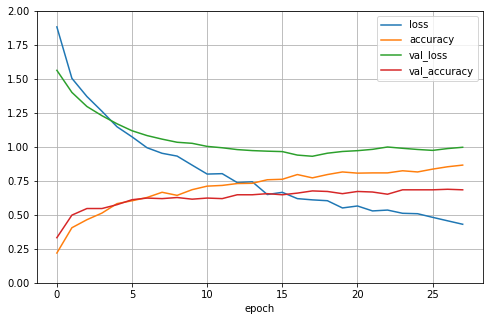

In [22]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.xlabel('epoch')
plt.show()

For each validation sample, the model returns an array of probabilities for each label. 

In [23]:
y_predicted

array([[6.5073981e-03, 2.0471206e-02, 8.6710358e-01, 1.6432520e-02,
        8.7745324e-02, 1.7399600e-03],
       [2.2112509e-02, 3.2037845e-01, 6.1096870e-03, 1.9633707e-02,
        1.8974909e-03, 6.2986821e-01],
       [2.6644759e-02, 1.9010236e-02, 9.4562221e-01, 4.5499871e-03,
        3.5556706e-04, 3.8171732e-03],
       ...,
       [8.7084681e-01, 7.6188780e-02, 1.1686203e-02, 1.3914254e-02,
        2.7485671e-03, 2.4615332e-02],
       [6.4638038e-03, 1.5398410e-01, 7.1549970e-01, 1.2030381e-01,
        1.3393197e-04, 3.6146028e-03],
       [6.0698675e-04, 2.4626902e-03, 9.9444515e-01, 1.9526567e-03,
        3.1803345e-04, 2.1450904e-04]], dtype=float32)

It is converted to 0 - 5 for generating the confusion matrix.

In [24]:
y_predicted = np.argmax(y_predicted, axis=1, out=None)
y_predicted

array([2, 5, 2, 5, 3, 5, 5, 4, 5, 5, 4, 0, 0, 5, 5, 0, 5, 3, 2, 3, 2, 2,
       5, 4, 3, 5, 5, 3, 4, 3, 5, 3, 5, 2, 5, 0, 0, 5, 4, 5, 0, 2, 0, 2,
       1, 4, 4, 4, 2, 5, 4, 2, 1, 0, 3, 5, 0, 1, 5, 5, 1, 0, 5, 5, 3, 3,
       2, 5, 3, 3, 1, 5, 0, 5, 1, 5, 3, 2, 5, 3, 5, 5, 5, 0, 5, 2, 1, 3,
       3, 0, 5, 5, 3, 1, 1, 3, 1, 5, 0, 4, 0, 2, 3, 5, 2, 3, 0, 2, 4, 3,
       5, 4, 2, 5, 4, 0, 1, 0, 2, 2, 3, 5, 1, 0, 4, 5, 2, 1, 3, 1, 1, 4,
       2, 2, 3, 2, 0, 5, 4, 1, 3, 0, 2, 0, 0, 5, 3, 1, 1, 2, 4, 2, 3, 5,
       2, 0, 5, 3, 1, 4, 2, 5, 5, 3, 1, 0, 1, 2, 4, 0, 5, 0, 3, 1, 0, 1,
       5, 3, 4, 3, 3, 4, 1, 4, 1, 4, 3, 4, 4, 1, 4, 4, 2, 1, 0, 4, 5, 1,
       1, 4, 3, 1, 3, 5, 1, 2, 2, 1, 2, 3, 3, 3, 2, 3, 4, 4, 1, 0, 5, 4,
       4, 1, 1, 5, 1, 4, 2, 0, 1, 1, 4, 5, 0, 5, 1, 1, 0, 2, 3, 5, 4, 3,
       1, 0, 0, 2, 2])

In [25]:
from sklearn.metrics import confusion_matrix

campus_cm = confusion_matrix(y_true.argmax(axis=1), y_predicted)
campus_cm

array([[23,  0,  0,  7,  0, 10],
       [ 1, 30,  3,  4,  1,  1],
       [ 1,  7, 32,  3,  1,  2],
       [ 5,  1,  2, 22,  5,  7],
       [ 0,  2,  1,  1, 28,  1],
       [ 5,  1,  0,  5,  1, 34]])

In [26]:
campus_cm_df = pd.DataFrame(campus_cm)
campus_cm_df.columns = ['canal','curve','ground','library','reception','square']
campus_cm_df.rename(index={0:'canal',1:'curve',2:'ground',3:'library',4:'reception',5:'square'}, inplace=True)
display(campus_cm_df)

,canal,curve,ground,library,reception,square
canal,23,0,0,7,0,10
curve,1,30,3,4,1,1
ground,1,7,32,3,1,2
library,5,1,2,22,5,7
reception,0,2,1,1,28,1
square,5,1,0,5,1,34


In [27]:
for i in range(6):
    print(f'The precision of predicting {campus_cm_df.columns[i]} is {campus_cm[i,i]/sum(campus_cm[i,:])}.')

The precision of predicting canal is 0.575.
The precision of predicting curve is 0.75.
The precision of predicting ground is 0.6956521739130435.
The precision of predicting library is 0.5238095238095238.
The precision of predicting reception is 0.8484848484848485.
The precision of predicting square is 0.7391304347826086.


In [28]:
for i in range(6):
    print(f'The sensitivity of predicting {campus_cm_df.columns[i]} is {campus_cm[i,i]/sum(campus_cm[:,i])}.')

The sensitivity of predicting canal is 0.6571428571428571.
The sensitivity of predicting curve is 0.7317073170731707.
The sensitivity of predicting ground is 0.8421052631578947.
The sensitivity of predicting library is 0.5238095238095238.
The sensitivity of predicting reception is 0.7777777777777778.
The sensitivity of predicting square is 0.6181818181818182.


In [29]:
from sklearn.metrics import f1_score
f = f1_score(y_true.argmax(axis=1), y_predicted, average=None)

for i in range(6):
    print(f'The F1-score of predicting {campus_cm_df.columns[i]} is {f[i]}.')

The F1-score of predicting canal is 0.6133333333333333.
The F1-score of predicting curve is 0.7407407407407408.
The F1-score of predicting ground is 0.761904761904762.
The F1-score of predicting library is 0.5238095238095238.
The F1-score of predicting reception is 0.8115942028985507.
The F1-score of predicting square is 0.6732673267326733.


Considering the F1-score, the model performs quite well in identifying audio segments recorded in curve, ground cafe and reception although the validation accuracy only 68.42%. Its performance is worst in predicting library samples. 

At the same time, a large difference in training and validation accuracies is observed, meaning that the model is overfitting the training samples even though early stopping and the dropout layers are applied.<br>
It is very likely that the model has reached its limit with the provided input.<br>
More meaningful features need to be extracted or more samples are required in order to improve the performance.

# 9 Conclusions

By adding more MFCC as features, a neural network architecture is trained to predict the recording spot of the campus data subset.<br>
With an overall validation accuracy of 68.42%, the model is good at predicting certain spots.<br>
However, the training process of neural network is very random and the trained model is not easy to interpret.<br>
If a seed is not fixed, the result will be different each time when the code is run.<br>
Moreover, different seeds may affect the final model.<br>
I have observed different trained models of similar accuracies but they are strong at predicting different spots.

On the other hand, there are actually too many hypermeters to tune such as the number of layers and the number of perceptrons in each layer, activation function, optimiser, learning rate, batch size, epochs, etc.

Overfitting is another problem in training neural network.<br>
In the experiment dropout layers are added into the model and early stopping is performed to try to avoid it.<br>
It may also require more meaningful features and training samples to improve the quality of the model.